In [3]:
!pip install numpy matplotlib


import numpy as np
import matplotlib.pyplot as plt


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached matplotlib-3.9.2-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.2.1-cp312-cp312-win_amd64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
Using cached matplotlib-3.9.2-cp312-cp312-win_amd64.whl (7.8 MB)
Using cached contourpy-1.2.1-cp312-cp312-win_amd64.whl (189 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)


In [4]:
def rosenbrock(x):
    """
    Computes the Rosenbrock function for a given 2-dimensional vector x.

    The Rosenbrock function is a non-convex function that is commonly used as a
    test problem for optimization algorithms. It has a global minimum at x = [1, 1]
    with a function value of 0.

    Args:
    - x: A 2-dimensional numpy array representing the point at which to evaluate
         the Rosenbrock function.

    Returns:
    - The value of the Rosenbrock function at the given point x.
    """
    return 10*(x[1]-x[0]**2)**2 + (1-x[0])**2


In [5]:
def gradient(x):
    """
    Computes the gradient of the Rosenbrock function for a given 2-dimensional vector x.

    The Rosenbrock function is a non-convex function that is commonly used as a test problem
    for optimization algorithms. The gradient of the Rosenbrock function is necessary to
    perform optimization using gradient-based methods.

    Args:
    - x: A 2-dimensional numpy array representing the point at which to evaluate the
         gradient of the Rosenbrock function.

    Returns:
    - A 2-dimensional numpy array representing the gradient of the Rosenbrock function
      evaluated at the given point x.
    """
    # Compute the gradient of the Rosenbrock function
    grad = np.array([
        -40*x[0]*x[1] + 40*x[0]**3 -2 + 2*x[0],
        20*(x[1]-x[0]**2)
    ])

    # Return the computed gradient
    return grad

In [6]:
def B(x):
    """
    Computes the Hessian matrix of the Rosenbrock function for a given 2-dimensional vector x.

    The Hessian matrix of the Rosenbrock function is necessary to perform optimization using
    Newton-based methods. The Hessian matrix represents the curvature of the Rosenbrock function
    at a given point.

    Args:
    - x: A 2-dimensional numpy array representing the point at which to evaluate the Hessian
         matrix of the Rosenbrock function.

    Returns:
    - A 2x2 numpy array representing the Hessian matrix of the Rosenbrock function evaluated at
      the given point x.
    """
    # Compute the Hessian matrix of the Rosenbrock function
    H = np.array([
        [120*x[0]*x[0] - 40*x[1] + 2, -40*x[0]],
        [-40*x[0], 20]
    ])

    # Return the computed Hessian matrix
    return H


In [7]:
def dogleg(g, B, delta):
    """
    Computes the dogleg step for a given gradient vector g, Hessian matrix B, and trust region radius delta.

    The dogleg step is used to determine the optimal direction to take in the optimization process.
    It is a hybrid of the Newton and steepest descent directions, and takes into account the
    trust region radius to ensure that the step size is within the bounds of the trust region.

    Args:
    - g: A numpy array representing the gradient vector of the Rosenbrock function at the current point.
    - B: A numpy array representing the Hessian matrix of the Rosenbrock function at the current point.
    - delta: A float representing the radius of the trust region.

    Returns:
    - A numpy array representing the dogleg step for the given gradient vector, Hessian matrix, and trust
      region radius.
    """

    # Compute the Newton step
    p_newton = -np.linalg.inv(B)@g

    # If the Newton step is within the trust region, return it
    if (np.linalg.norm(p_newton) <= delta):
        return p_newton
    
    # Otherwise, compute the Cauchy point and the dogleg point
    else:
        # Compute the Cauchy point
        p_temp = -delta*g/np.linalg.norm(g)
        
        # Determine the value of tau based on the curvature of the Rosenbrock function at the current point
        if (np.dot(g, np.matmul(B, g)) <= 0):
            tau = 1
        else:
            num = np.linalg.norm(g)**3
            den = delta*np.dot(g, np.matmul(B, g))
            tau = min(num/den, 1)

        # Compute the dogleg point using alpha
        p_cauchy = tau*p_temp
        a = np.linalg.norm(p_newton-p_cauchy)**2
        b = np.dot(p_cauchy, p_newton-p_cauchy)
        c = np.linalg.norm(p_cauchy)**2 - delta*delta
        b2 = np.dot(b, b)
        ac = np.dot(a,c)
        alpha = (-b + np.sqrt(b2-ac))/(a)
        p_dogleg = p_cauchy+alpha*(p_newton-p_cauchy)
        
        return p_dogleg

In [8]:
"""
This code calls the dogleg() function with inputs (gradient([2,2]), B([2,2]), 5), 
which computes the dogleg step for the Rosenbrock function at the point (2,2), with a trust region radius of 5.

"""

dogleg(gradient([2,2]), B([2,2]), 5)

array([-0.02439024,  1.90243902])

### Algorithm to find the trust region using the dogleg method.


In [9]:
def trust_region_dogleg(function, grad, hess, x0, delta=1.0,
                        max_trust_radius=100.0, eta=0.15, gtol=1e-4,
                        maxiter=100):
    """
    Computes the trust region_dogleg


    This code implements the trust region dogleg algorithm to find the minimum of a function. It takes the following inputs:
    
    Args:
    - function: the objective function to minimize
    - grad: the gradient of the objective function
    - hess: the Hessian matrix of the objective function
    - x0: the initial guess
    - delta: the initial trust region radius
    - max_trust_radius: the maximum allowed trust region radius
    - eta: the acceptable ratio of actual reduction to predicted reduction
    - gtol: the tolerance for the gradient norm
    - maxiter: the maximum number of iterations
    
    Returns:
    This dogleg function to compute the step direction and updates the trust region radius based on the ratio of actual to predicted reduction. 
    It also tracks the history of x values and plots the trajectory on top of the contour plot of the Rosenbrock function.
    
    """
    xk = x0
    trust_rad_k = delta
    k = 0
    p = np.array([x0[0]])
    y = np.array([x0[1]])
    
    while True:

        gk = grad(xk)
        Bk = hess(xk)

        pk = dogleg(gk, Bk, trust_rad_k)

        # Actual reduction.
        act_red = function(xk) - function(xk + pk)

        # Predicted reduction.
        pred_red = -(np.dot(gk, pk) + 0.5 * np.dot(pk, np.dot(Bk, pk)))

        # Rho.
        rhok = act_red / pred_red
        if pred_red == 0.0:
            rhok = 1e99
        else:
            rhok = act_red / pred_red

        # Calculate the Euclidean norm of pk.
        norm_pk = np.sqrt(np.dot(pk, pk))

        # Rho is close to zero or negative, therefore the trust region is shrunk.
        if rhok < 0.25:
            trust_rad_k = 0.25 * norm_pk
        else:
            # Rho is close to one and pk has reached the boundary of the trust region, therefore the trust region is expanded.
            if rhok > 0.75 and norm_pk == trust_rad_k:
                trust_rad_k = min(2.0 * trust_rad_k, max_trust_radius)
            else:
                trust_rad_k = trust_rad_k

        # Choose the position for the next iteration.
        if rhok > eta:
            xk = xk + pk
        else:
            xk = xk

        # Check if the gradient is small enough to stop
        if np.linalg.norm(gk) < gtol:
            break

        # Check if we have looked at enough iterations
        if k >= maxiter:
            break
        k = k + 1
        print(k, xk, rhok, trust_rad_k, gk)
        p = np.append(p, xk[0])
        y = np.append(y, xk[1])


        # Define a grid of x and y values
    x_vals = np.linspace(-2.5, 2.5, 50)
    y_vals = np.linspace(-4, 4, 50)
    X, Y = np.meshgrid(x_vals, y_vals)

    # Compute the Rosenbrock function over the grid
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i,j] = rosenbrock(np.array([X[i,j], Y[i,j]]))

    # Define an initial point
    x = np.array([1.0, 1.0])
    tol = 1e-6
    # Perform the trust region algorithm with history tracking
    x_hist = [x]
    while np.linalg.norm(gradient(x)) > tol:
        p = dogleg(x, delta)
        x += p
        x_hist.append(x)

    # Plot the contour plot and trajectory
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.contour(X, Y, Z, levels=90)
    ax.plot([x[0] for x in x_hist], [x[1] for x in x_hist], marker='o')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.plot(p, y)
    ax.set_title('Contour Plot of Rosenbrock Function with Trust Region Trajectory')
    plt.show()

    return xk

1 [-1.85714286  3.42857143] 1.0387395662766084 1.0 [-86 -20]
2 [-1.57572767  2.46898532] 1.0500463577206507 2.0 [-7.2303207  -0.40816327]
3 [-0.95082235  0.56911866] 0.6349975106349344 2.0 [-6.02959936 -0.27864714]
4 [-0.69743226  0.42220521] 1.240618994117512 2.0 [-16.64055257  -6.69888959]
5 [-0.69743226  0.42220521] -0.7968883526401105 0.3059587932222957 [-5.18605297 -1.28413078]
6 [-0.46133688  0.22760368] 1.178936746477865 0.6119175864445914 [-5.18605297 -1.28413078]
7 [ 0.04412103 -0.11729549] 0.9712349761442682 1.2238351728891828 [-2.65007971  0.29543926]
8 [0.32652082 0.0268662 ] 1.3071634363551548 1.2238351728891828 [-1.70131448 -2.38484301]
9 [0.58605108 0.27609992] 1.2603484587092904 1.2238351728891828 [-0.30536157 -1.59499288]
10 [0.76241577 0.5501733 ] 1.2722431367275373 1.2238351728891828 [ 0.7510634  -1.34711912]
11 [0.90888374 0.80461678] 1.1965975878351425 1.2238351728891828 [ 0.47341401 -0.62209002]
12 [0.97264343 0.94196995] 1.151652908726519 1.2238351728891828 [ 0.5

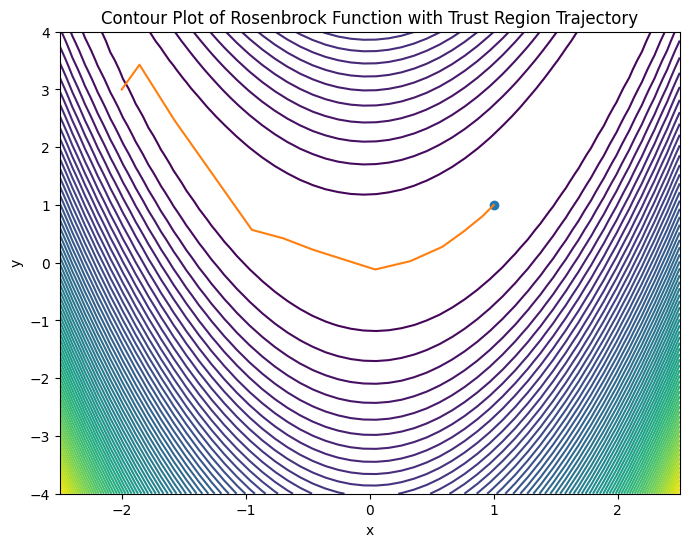

Result of trust region dogleg method:  [1. 1.]
Value of function at a point:  5.5590041914793176e-30


In [10]:
result = trust_region_dogleg(rosenbrock, gradient, B, [-2, 3])

print("Result of trust region dogleg method: ", result)
print("Value of function at a point: ", (rosenbrock(result)))